In [ ]:
import matplotlib.pyplot as plt

plt.style.use('default')
plt.rcParams.update({
    'font.size': 12,             
    'axes.labelsize': 12,        
    'axes.titlesize': 14,        
    'xtick.labelsize': 12,       
    'ytick.labelsize': 12,       
    'legend.fontsize': 12,       
    'figure.titlesize': 14       
})

true_batch_names = {
    "01_Zwickelbier": "1. Zwickelbier",
    "02_Zwickelbier": "2. Zwickelbier",
    "03_Zwickelbier": "3. Zwickelbier",
    "04_Wiener_Lager": "Vienna Lager",
    "05_European_Red_Lager": "European Red Lager",
    "06_Uni_Pils": "Pilsner"
}

## Data Loading

In [2]:
import re
import polars as pl

df_dsa = pl.read_ipc("data/Beer_Analyzer_Data_full.feather")
df_nir = pl.read_ipc("data/Fermentation_NIR_absorbance_full.feather")

df_dsa = df_dsa.with_columns(
    pl.col('BatchName').cast(pl.Utf8)
)

# Reverse NIR columns to match wavelength order (wavenumber to wavelength conversion)
regex_pattern = r"^WL.*$"
cols_to_reverse = [col for col in df_nir.columns if re.match(regex_pattern, col)]

reversal_map = dict(zip(cols_to_reverse, cols_to_reverse[::-1]))

df_nir = df_nir.select(
    [
        pl.col(reversal_map[col]).alias(col) if col in reversal_map
        else pl.col(col)
        for col in df_nir.columns
    ]
)

Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.


Number of spectra and samples from the individual batches

In [3]:
counts_spectra = df_nir["BatchName"].value_counts().sort("BatchName")
counts_samples = df_dsa["BatchName"].value_counts().sort("BatchName")

counts = counts_spectra.join(counts_samples, on="BatchName")
counts = counts.rename({"count": "n_spectra", "count_right": "n_samples"})

counts

BatchName,n_spectra,n_samples
str,u32,u32
"""01_Zwickelbier""",7084,14
"""02_Zwickelbier""",6597,15
"""03_Zwickelbier""",10659,16
"""04_Wiener_Lager""",6128,14
"""05_European_Red_Lager""",6473,16
"""06_Uni_Pils""",6371,16


## Outlier detection

Plot saved to figures/spectra_by_batch.png


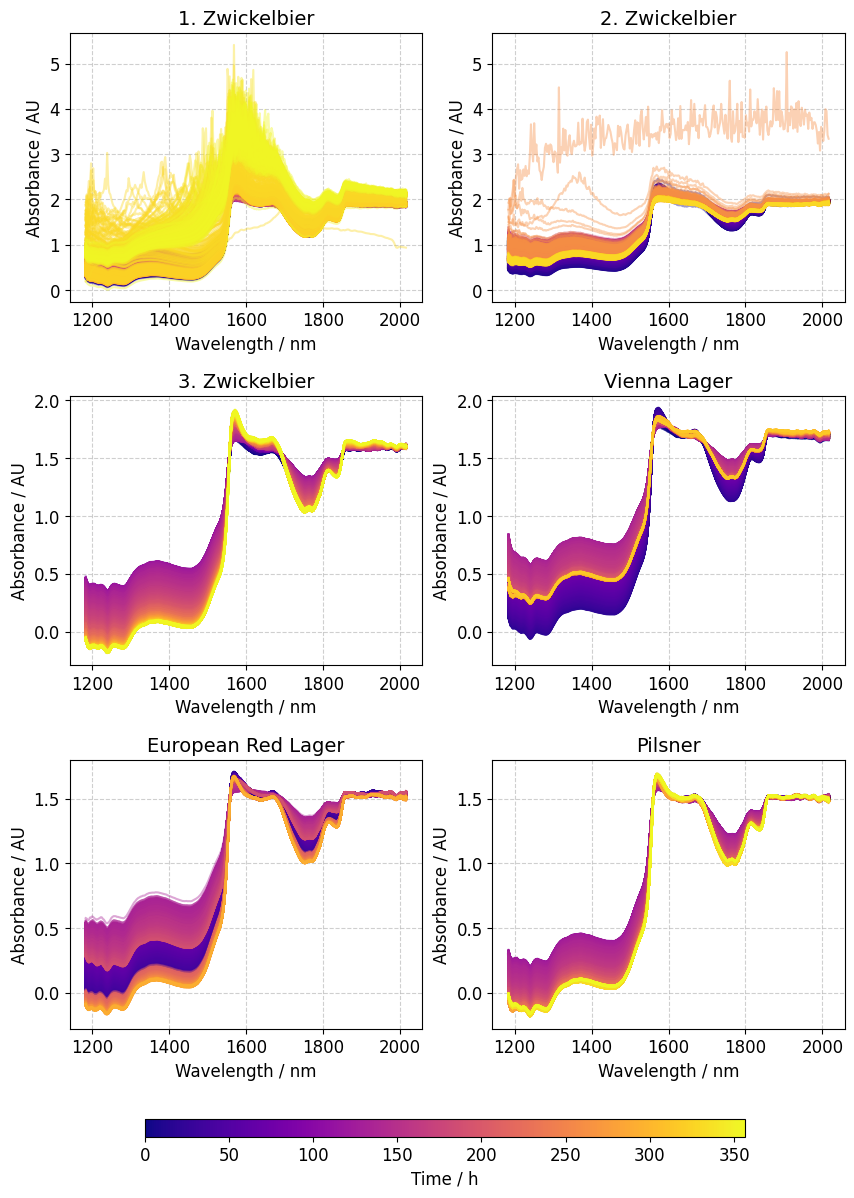

In [4]:
from NIRBeer.visualization import plot_spectra_by_batch
from sklearn.pipeline import Pipeline
from chemotools.feature_selection import RangeCut
import numpy as np

true_batch_names = ["1. Zwickelbier", "2. Zwickelbier", "3. Zwickelbier", "Vienna Lager", "European Red Lager", "Pilsner"]
wavelengths = np.linspace(1100, 2100, 359)
preprocessing = Pipeline([
    ('range_cut', RangeCut(30, -30)),
])

plot_spectra_by_batch(df_nir, wavelengths, 
                      batch_names=true_batch_names, 
                      preprocessing=preprocessing, 
                      n_cols=2, 
                      output_filename="figures/spectra_by_batch.png",
                      row_spacing=0.35
                      )

In [2]:
from NIRBeer.outlier_detection import detect_outliers
from chemotools.feature_selection import RangeCut
from sklearn.pipeline import Pipeline

preprocessing = Pipeline([("range_cut", RangeCut(30, -30))])

result = detect_outliers(df_nir, alpha=0.05, var_threshold=0.95, preprocessing=preprocessing)

print("Removed", df_nir.shape[0] - result.num_inliers, "outliers")

Removed 1250 outliers


Plot saved to figures/improved_outlier_plot.jpg


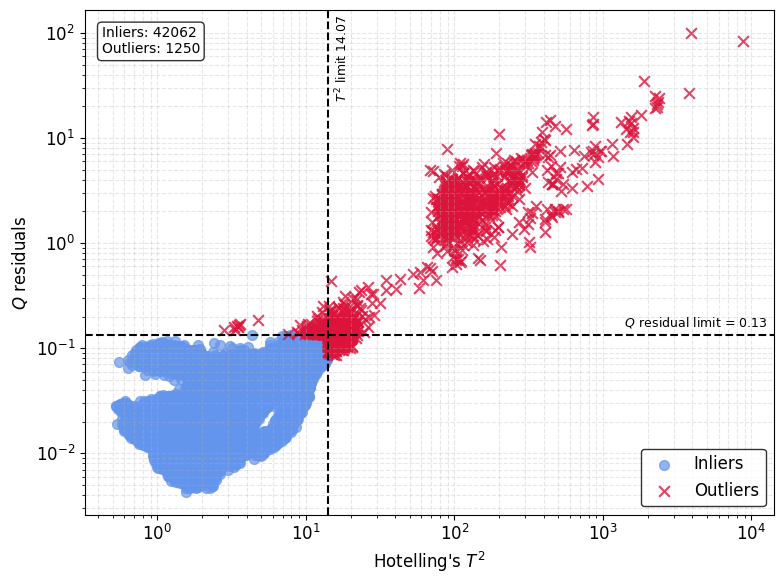

In [7]:
from NIRBeer.visualization import plot_detected_outliers

plot_detected_outliers(result.t2, result.q, result.inliers_mask, result.t2_limit, result.q_limit,
                           output_filename="figures/improved_outlier_plot.jpg")

Plot saved to figures/spectra_by_batch_outliers_removed.png


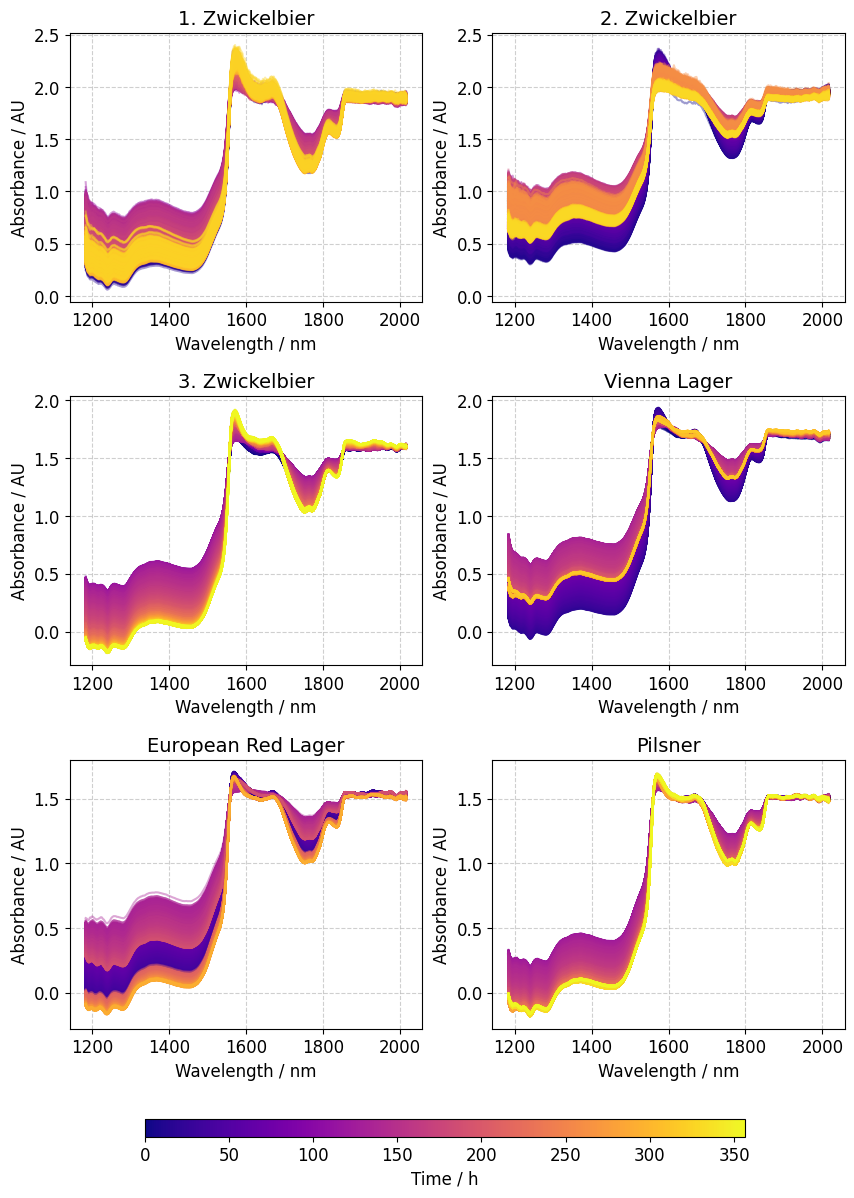

In [9]:
from NIRBeer.visualization import plot_spectra_by_batch
from sklearn.pipeline import Pipeline
from chemotools.feature_selection import RangeCut
import numpy as np

df_nir_clean = result.df_inliers
true_batch_names = ["1. Zwickelbier", "2. Zwickelbier", "3. Zwickelbier", "Vienna Lager", "European Red Lager", "Pilsner"]
wavelengths = np.linspace(1100, 2100, 359)
preprocessing = Pipeline([
    ('range_cut', RangeCut(30, -30)),
])

plot_spectra_by_batch(df_nir_clean, 
                      wavelengths, 
                      batch_names=true_batch_names, 
                      preprocessing=preprocessing, 
                      n_cols=2, 
                      output_filename="figures/spectra_by_batch_outliers_removed.png",
                      row_spacing=0.35
                      )

## Data sampling

In [5]:
from NIRBeer.interpolation import interpolate_targets_to_spectra
from NIRBeer.sampling import adaptive_time_sampler

df_interpolate = interpolate_targets_to_spectra(result.df_inliers, df_dsa)

min_time = 3 
max_time = 16
k_rate = 50
exponent = 3 / 2

selected_df = df_interpolate.group_by("BatchName", maintain_order=True).map_groups(
    lambda df_group: adaptive_time_sampler(
        df_group,
        min_dt=min_time,
        max_dt=max_time,
        rate_k=k_rate,
        exp_val=exponent
    )
)

selected_df

TimeStamp,CumulativeTime,BatchName,WL1,WL2,WL3,WL4,WL5,WL6,WL7,WL8,WL9,WL10,WL11,WL12,WL13,WL14,WL15,WL16,WL17,WL18,WL19,WL20,WL21,WL22,WL23,WL24,WL25,WL26,WL27,WL28,WL29,WL30,WL31,WL32,WL33,WL34,…,WL328,WL329,WL330,WL331,WL332,WL333,WL334,WL335,WL336,WL337,WL338,WL339,WL340,WL341,WL342,WL343,WL344,WL345,WL346,WL347,WL348,WL349,WL350,WL351,WL352,WL353,WL354,WL355,WL356,WL357,WL358,WL359,Ereal_interp,wtPercEtOH_interp,dE_dt,dEtOH_dt,derivative_magnitude
datetime[ns],f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-02-22 19:34:54,0.0,"""01_Zwickelbier""",1.737227,2.065911,1.499288,1.351655,1.418881,1.807379,1.395971,1.587566,2.087338,1.778735,1.654735,1.600581,1.402441,1.96746,1.642156,1.826204,1.573968,1.540475,1.28133,1.06226,1.442099,1.164525,0.942904,0.872628,0.825228,0.719547,0.773006,0.723369,0.703287,0.63486,0.615416,0.593451,0.558627,0.536177,…,1.925785,1.920295,1.898796,1.893569,1.923817,1.942874,1.910703,1.861964,1.830387,1.888273,1.808025,1.850439,1.862269,1.802914,1.844475,1.695239,1.768077,1.641216,1.928454,1.884227,2.270877,1.857789,2.329023,1.970147,1.52893,1.560237,1.442495,1.230953,2.008538,1.610804,1.455327,1.34102,12.638252,0.0,-0.022169,0.011476,0.024964
2024-02-22 22:34:54,3.0,"""01_Zwickelbier""",1.632558,1.571386,1.48024,1.688692,1.883242,1.331484,2.054059,1.253544,1.572243,1.851939,1.493703,1.982442,1.47251,1.488149,1.621244,1.388659,1.432134,1.346405,1.096586,1.075456,0.941538,0.833864,0.755463,0.715873,0.646344,0.573051,0.562864,0.540895,0.537266,0.480774,0.476117,0.430913,0.396185,0.380223,…,1.892769,1.911733,1.885068,1.893361,1.90237,1.88566,1.862108,1.812075,1.851074,1.834649,1.861677,1.795125,1.873505,1.796447,1.748924,1.896704,1.742064,1.872315,1.921911,1.947995,1.981295,1.890915,1.801594,1.415206,1.400323,1.340754,1.088557,1.336624,1.277674,1.334794,2.035215,1.47729,12.572443,0.034068,-0.021689,0.011228,0.024423
2024-02-23 01:34:54,6.0,"""01_Zwickelbier""",1.830203,1.708162,1.41674,2.520643,1.577582,1.792946,1.522851,1.283086,1.988276,1.287148,1.62614,1.715066,1.326881,1.54963,1.408692,1.439484,1.302311,1.418614,1.095883,1.021776,0.818551,0.632564,0.667601,0.629911,0.548297,0.469999,0.456495,0.442006,0.460362,0.403742,0.391655,0.359657,0.32836,0.314912,…,1.866738,1.905743,1.889382,1.88285,1.875603,1.876232,1.8815,1.924495,1.828883,1.899982,1.857163,1.774186,1.766127,1.772831,1.765883,1.723421,1.68498,1.687723,1.709436,1.87349,1.806409,1.832581,1.53587,1.557895,1.438751,1.432668,1.102259,1.148758,1.391033,1.455909,2.238534,2.081734,12.508199,0.067325,-0.021126,0.010936,0.023789
2024-02-23 04:34:54,9.0,"""01_Zwickelbier""",1.6899,1.543966,1.900399,2.084077,1.43007,1.616983,2.134215,1.515153,1.417472,1.671983,1.756258,1.81344,1.803645,1.919846,2.674924,1.4727,1.686095,1.220629,1.1984,0.997781,0.956467,0.759419,0.736418,0.702806,0.677885,0.574401,0.546667,0.546863,0.532826,0.487711,0.490571,0.437101,0.394463,0.382275,…,1.87593,1.891509,1.887746,1.870569,1.843831,1.844801,1.886243,1.850386,1.829395,1.791975,1.754635,1.761213,1.67716,1.78516,1.700512,1.757809,1.693433,1.656623,1.706128,1.600252,1.538423,1.493604,1.460085,1.444159,1.085857,1.2796,1.069993,1.07986,1.061559,1.136417,1.214383,1.226923,12.44577,0.099643,-0.020479,0.010602,0.023061
2024-02-23 07:37:55,12.050278,"""01_Zwickelbier""",1.543706,1.503131,1.41525,1.370686,1.4092,1.621265,2.202326,1.69848,1.96909,1.309868,1.839804,1.260038,1.694345,1.714411,1.6889,1.768907,1.748202,2.424844,1.559668,1.082042,0.960279,0.934168,0.915357,0.773232,0.733428,0.593766,0.602621,0.624544,0.572053,0.565927,0.554752,0.48674,0.472174,0.465896,…,1.897547,1.880025,1.894562,1.916085,1.926653,1.903318,1.903125,1.855057,1.870341,1.873413,1.801491,1.783961,1.749945,1.736892,1.73114,1.935087,1.667361,1.676759,1.729254,1.96

In [6]:
selected_df.group_by("BatchName").len()

BatchName,len
str,u32
"""01_Zwickelbier""",70
"""02_Zwickelbier""",80
"""03_Zwickelbier""",85
"""04_Wiener_Lager""",70
"""05_European_Red_Lager""",64
"""06_Uni_Pils""",83


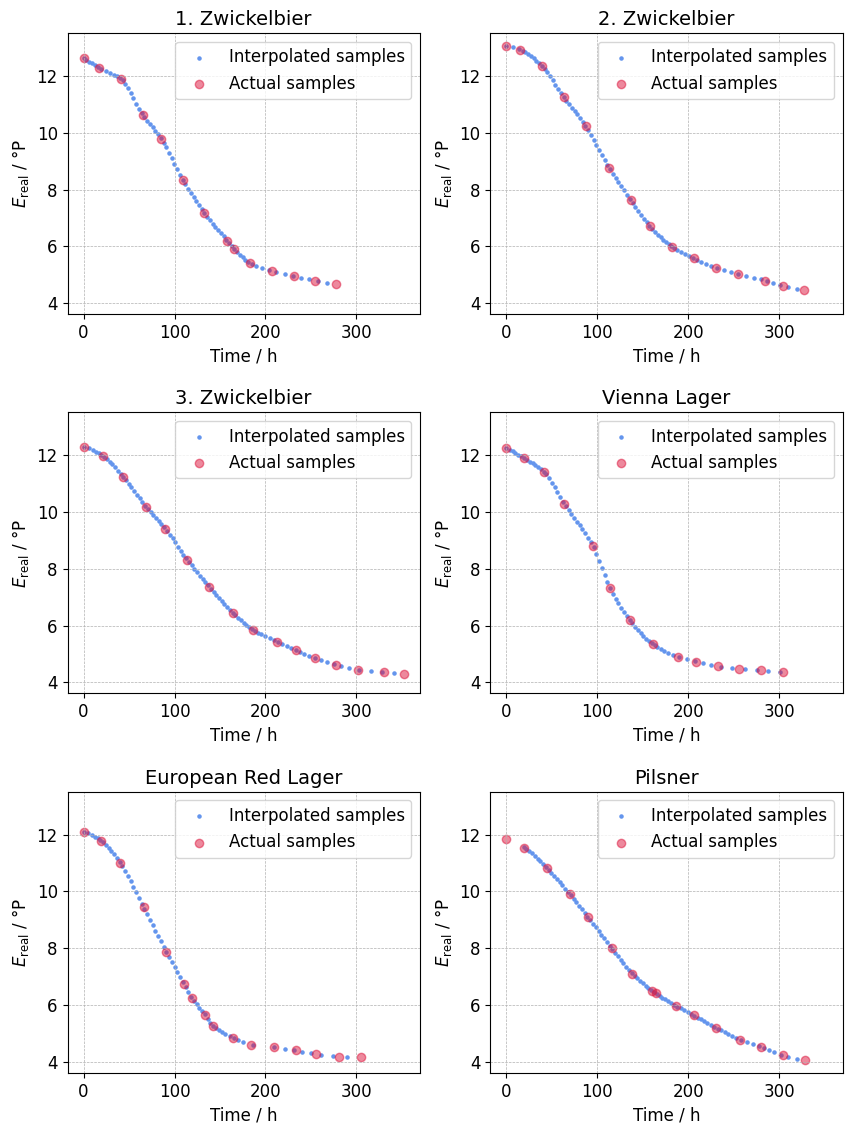

In [7]:
from NIRBeer.visualization import plot_interpolation

plot_interpolation(selected_df, 
                  df_dsa, 
                  target_col="Ereal", 
                  target_ylabel=r"$E_{\text{real}}$ / °P", 
                  batch_name_map=true_batch_names
                  )

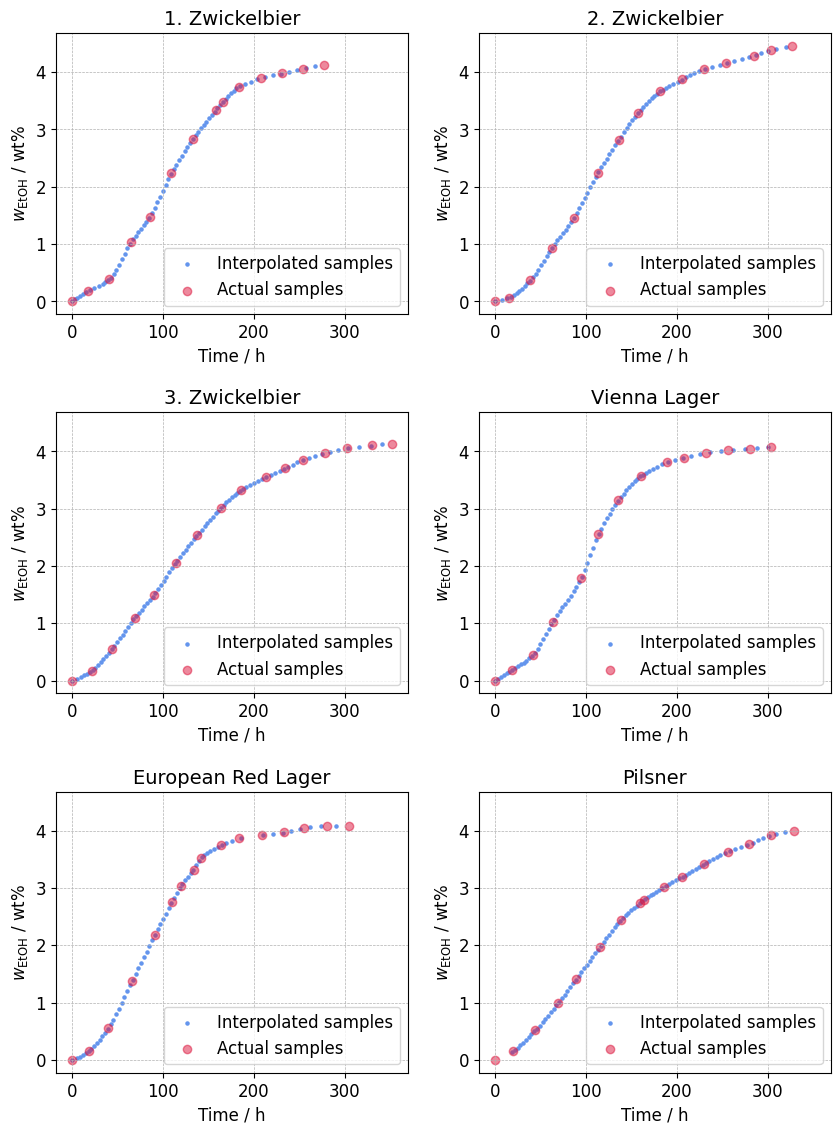

In [9]:
from NIRBeer.visualization import plot_interpolation

plot_interpolation(selected_df, 
                  df_dsa, 
                  target_col="wtPercEtOH", 
                  target_ylabel=r"$w_{\text{EtOH}}$ / wt%", 
                  batch_name_map=true_batch_names
                  )

## Grid-Search hyperparameter selection for PLS regression


--- Training Separate Model 1/2 ---
Starting GridSearchCV for holdout '05_European_Red_Lager' on 397 samples...
Model saved to 'models/PLS_without_05_European_Red_Lager.joblib'
Holdout MSE for Real Extract: 0.1135, $R^2$: 0.9845
Holdout MSE for Ethanol: 0.0412, $R^2$: 0.9789

--- Training Separate Model 2/2 ---
Starting GridSearchCV for holdout '06_Uni_Pils' on 375 samples...
Model saved to 'models/PLS_without_06_Uni_Pils.joblib'
Holdout MSE for Real Extract: 0.2451, $R^2$: 0.9539
Holdout MSE for Ethanol: 0.0291, $R^2$: 0.9794


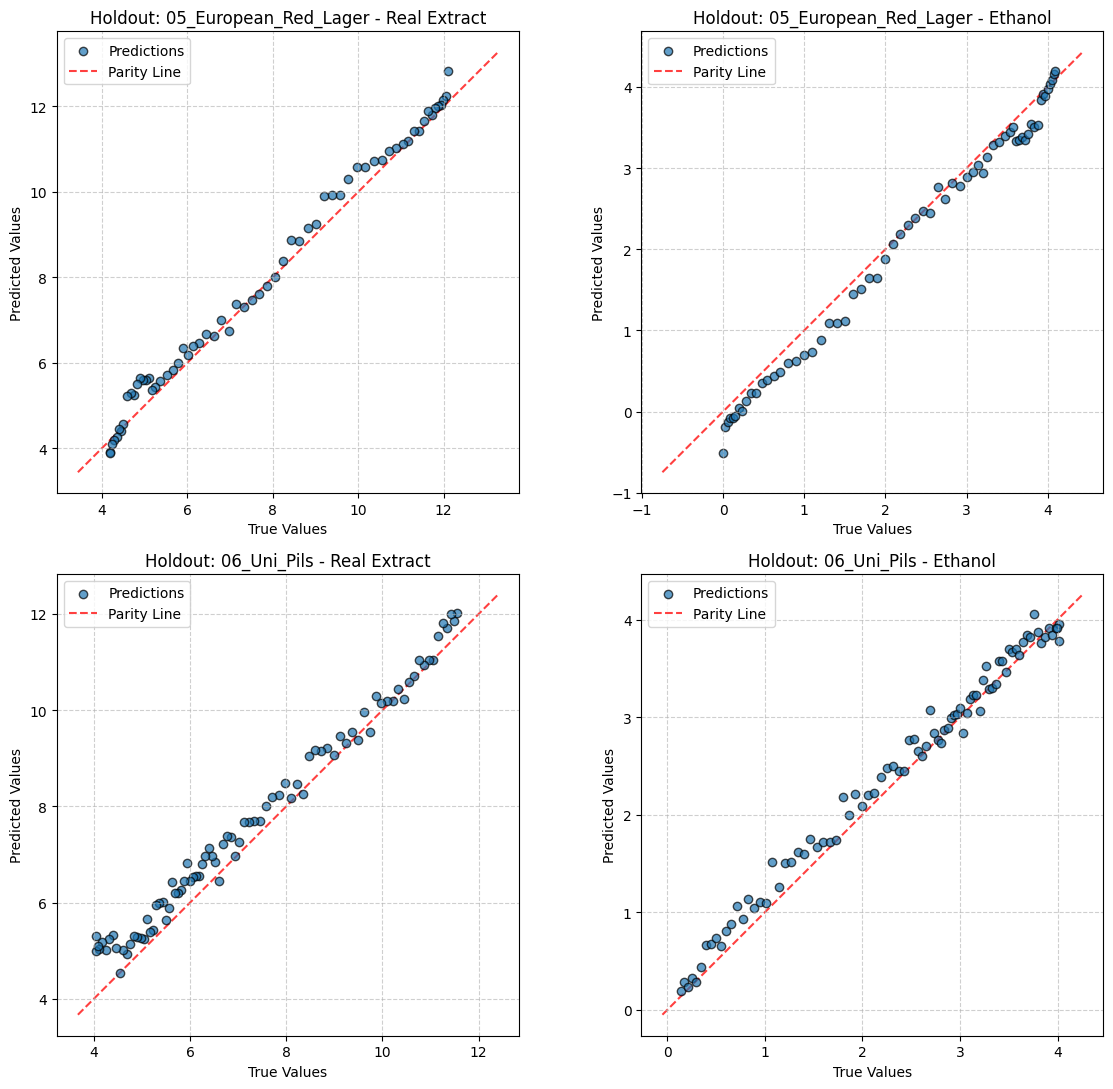

[{'holdout_batch': '05_European_Red_Lager',
  'best_params': {'regressor__emsc__order': np.int64(1),
   'regressor__pls__n_components': np.int64(7),
   'regressor__sg__polynomial_order': np.int64(2),
   'regressor__sg__window_size': np.int64(11),
   'regressor__vip__vip_threshold': np.float64(0.8999999999999999)},
  'mse_real_extract': np.float64(0.11348741870696903),
  'r2_real_extract': 0.9845419780699182,
  'mse_ethanol': np.float64(0.041173185991653455),
  'r2_ethanol': 0.9789475997151286},
 {'holdout_batch': '06_Uni_Pils',
  'best_params': {'regressor__emsc__order': np.int64(1),
   'regressor__pls__n_components': np.int64(7),
   'regressor__sg__polynomial_order': np.int64(4),
   'regressor__sg__window_size': np.int64(18),
   'regressor__vip__vip_threshold': np.float64(1.4)},
  'mse_real_extract': np.float64(0.24505369549347866),
  'r2_real_extract': 0.9539181019848323,
  'mse_ethanol': np.float64(0.029071910501906086),
  'r2_ethanol': 0.9794173404133427}]

In [ ]:
from NIRBeer.model_training import train_and_evaluate
from sklearn.cross_decomposition import PLSRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from chemotools.scatter import ExtendedMultiplicativeScatterCorrection
from chemotools.derivative import SavitzkyGolay
from NIRBeer.feature_selection import VIPSelector
import numpy as np

df = selected_df
holdout_batch = ["05_European_Red_Lager", "06_Uni_Pils"]

pipeline = Pipeline([
        ('rangecut', RangeCut(30, -30)),
        # Hier savitzky
        ('emsc', ExtendedMultiplicativeScatterCorrection()),
        ('sg', SavitzkyGolay(derivate_order=1)),
        ('scaler', StandardScaler()),
        ('vip', VIPSelector(n_components_pls=3)),
        ('pls', PLSRegression(scale=False))
    ])

param_grid = {
        'regressor__pls__n_components': np.arange(3, 9),  # Example range of components to try
        'regressor__vip__vip_threshold': np.arange(0.5, 1.5, 0.1),  # Example thresholds to try
        'regressor__emsc__order': np.arange(1, 2),  # Example orders to try
        'regressor__sg__window_size': np.arange(11, 20, 1),  # Example window sizes to try
        'regressor__sg__polynomial_order': np.arange(2, 5, 1),
    }

train_and_evaluate(df, holdout_batch, pipeline, f"models/PLS_gridsearch", param_grid=param_grid)

## Final PLS models


--- Training Separate Model 1/2 ---
Fitting model for holdout '05_European_Red_Lager' on 388 samples...
Model saved to 'models/PLS_final_without_05_European_Red_Lager.joblib'
Holdout MSE for Real Extract: 0.1287, $R^2$: 0.9825
Holdout MSE for Ethanol: 0.0341, $R^2$: 0.9826

--- Training Separate Model 2/2 ---
Fitting model for holdout '06_Uni_Pils' on 369 samples...
Model saved to 'models/PLS_final_without_06_Uni_Pils.joblib'
Holdout MSE for Real Extract: 0.0458, $R^2$: 0.9910
Holdout MSE for Ethanol: 0.0234, $R^2$: 0.9828


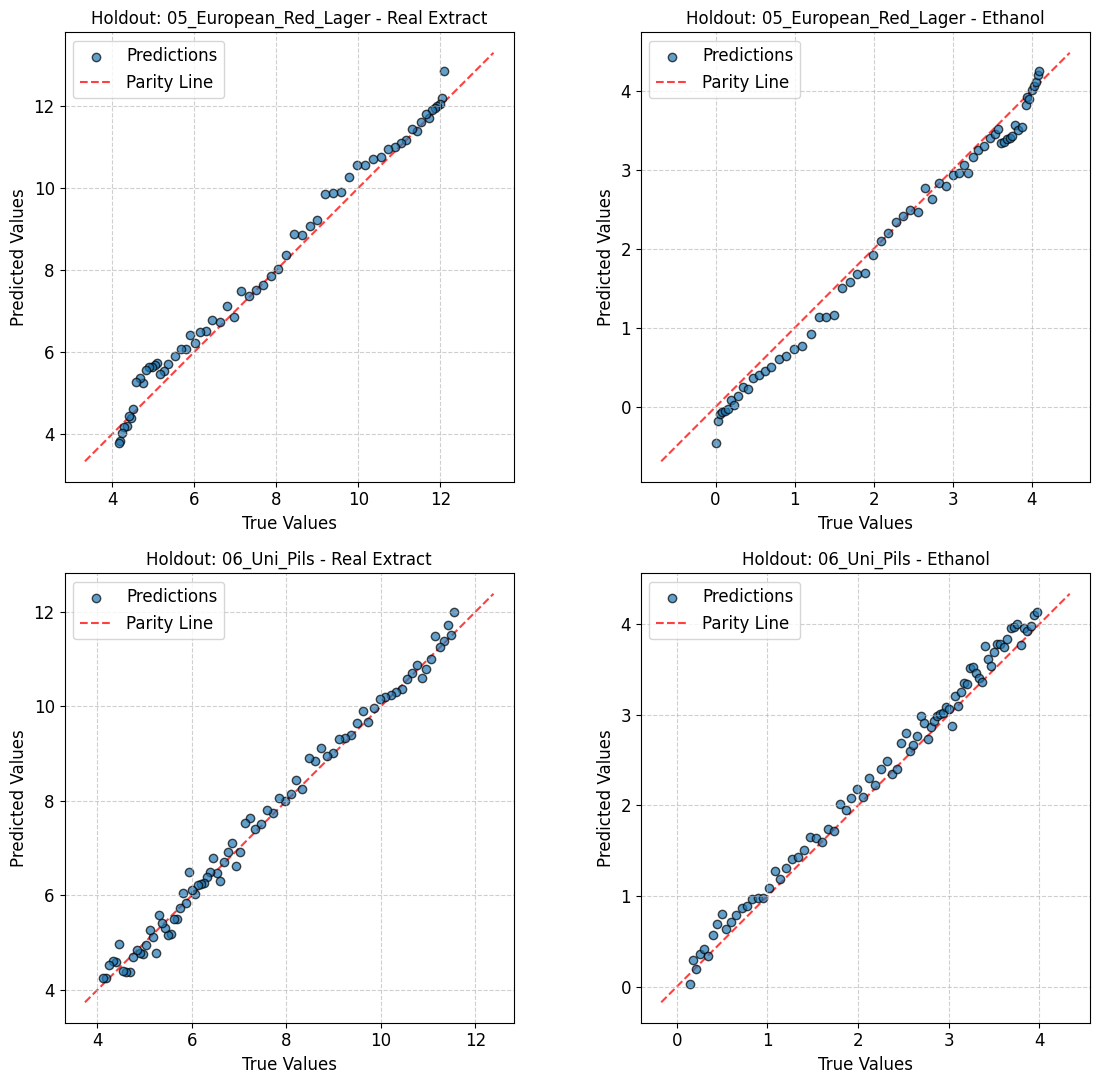

[{'holdout_batch': '05_European_Red_Lager',
  'best_params': 'Defaults',
  'mse_real_extract': 0.1287443007042527,
  'r2_real_extract': 0.9824638515323181,
  'mse_ethanol': 0.034102878768132845,
  'r2_ethanol': 0.9825627422944944},
 {'holdout_batch': '06_Uni_Pils',
  'best_params': 'Defaults',
  'mse_real_extract': 0.04578228215497604,
  'r2_real_extract': 0.991042100873105,
  'mse_ethanol': 0.02337775348454778,
  'r2_ethanol': 0.9827785259788191}]

In [11]:
from NIRBeer.model_training import train_and_evaluate
from sklearn.cross_decomposition import PLSRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from chemotools.scatter import ExtendedMultiplicativeScatterCorrection, StandardNormalVariate
from chemotools.derivative import SavitzkyGolay
from NIRBeer.feature_selection import VIPSelector
import numpy as np

df = selected_df
holdout_batch = ["05_European_Red_Lager", "06_Uni_Pils"]

pipeline = Pipeline([
        ('rangecut', RangeCut(30, -30)),
        ('emsc', ExtendedMultiplicativeScatterCorrection(order=1)),
        ('sg', SavitzkyGolay(polynomial_order=2, window_size=11, derivate_order=1)),
        ('scaler', StandardScaler()),
        ('vip', VIPSelector(n_components_pls=7, vip_threshold=0.95)),
        ('pls', PLSRegression(n_components=7, scale=False))
    ])

train_and_evaluate(df, holdout_batch, pipeline, f"models/PLS_final", separate_models=True)

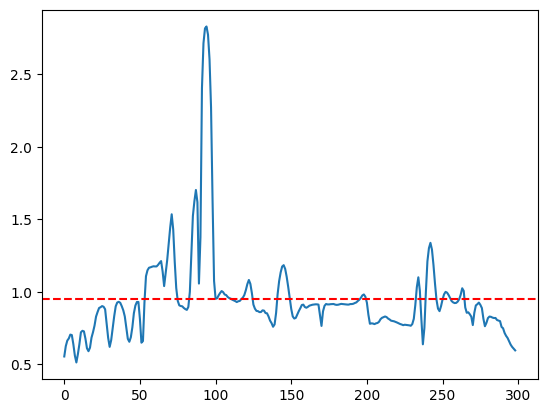

In [35]:
import joblib
import matplotlib.pyplot as plt

ttr = joblib.load("models/PLS_final_without_05_European_Red_Lager.joblib")

vip = ttr.regressor_['vip']

plt.plot(vip.vip_scores)
plt.axhline(0.95, color='r', linestyle='--')

## Performance over course of fermentation
European Red Lager

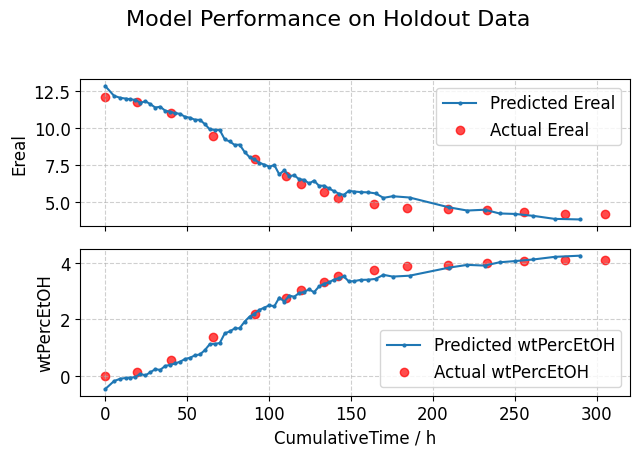

In [27]:
import joblib
from NIRBeer.visualization import plot_model_performance

holdout_batch = "05_European_Red_Lager"  # Change this to visualize different batches
best_model = joblib.load(f'models/PLS_final_without_{holdout_batch}.joblib')

plot_model_performance(
    model=best_model,
    spectra_holdout_df=selected_df,
    actuals_holdout_df=df_dsa,
    holdout_batch=holdout_batch,
    target_columns=["Ereal", "wtPercEtOH"]
)

Uni Pils

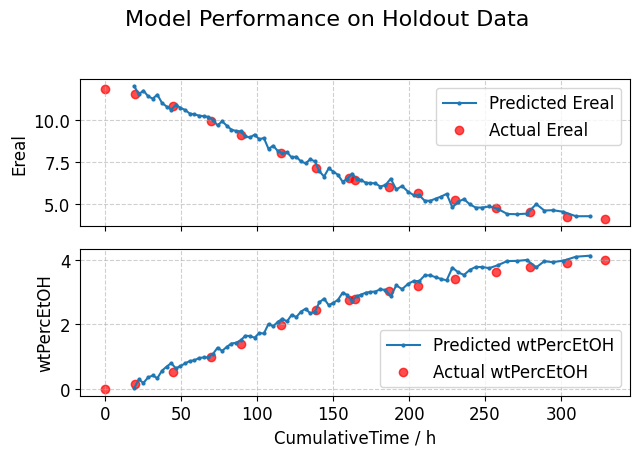

In [28]:
import joblib
from NIRBeer.visualization import plot_model_performance

holdout_batch = "06_Uni_Pils"  # Change this to visualize different batches
best_model = joblib.load(f'models/PLS_final_without_{holdout_batch}.joblib')

plot_model_performance(
    model=best_model,
    spectra_holdout_df=selected_df,
    actuals_holdout_df=df_dsa,
    holdout_batch=holdout_batch,
    target_columns=["Ereal", "wtPercEtOH"]
)

## Grid-Search hyperparameter selection for MLP regression


--- Training Separate Model 1/2 ---
Starting GridSearchCV for holdout '05_European_Red_Lager' on 397 samples...
Model saved to 'models/MLP_gridsearch_without_05_European_Red_Lager.joblib'
Holdout MSE for Real Extract: 0.0579, $R^2$: 0.9921
Holdout MSE for Ethanol: 0.0137, $R^2$: 0.9930

--- Training Separate Model 2/2 ---
Starting GridSearchCV for holdout '06_Uni_Pils' on 375 samples...
Model saved to 'models/MLP_gridsearch_without_06_Uni_Pils.joblib'
Holdout MSE for Real Extract: 0.1520, $R^2$: 0.9714
Holdout MSE for Ethanol: 0.0169, $R^2$: 0.9880


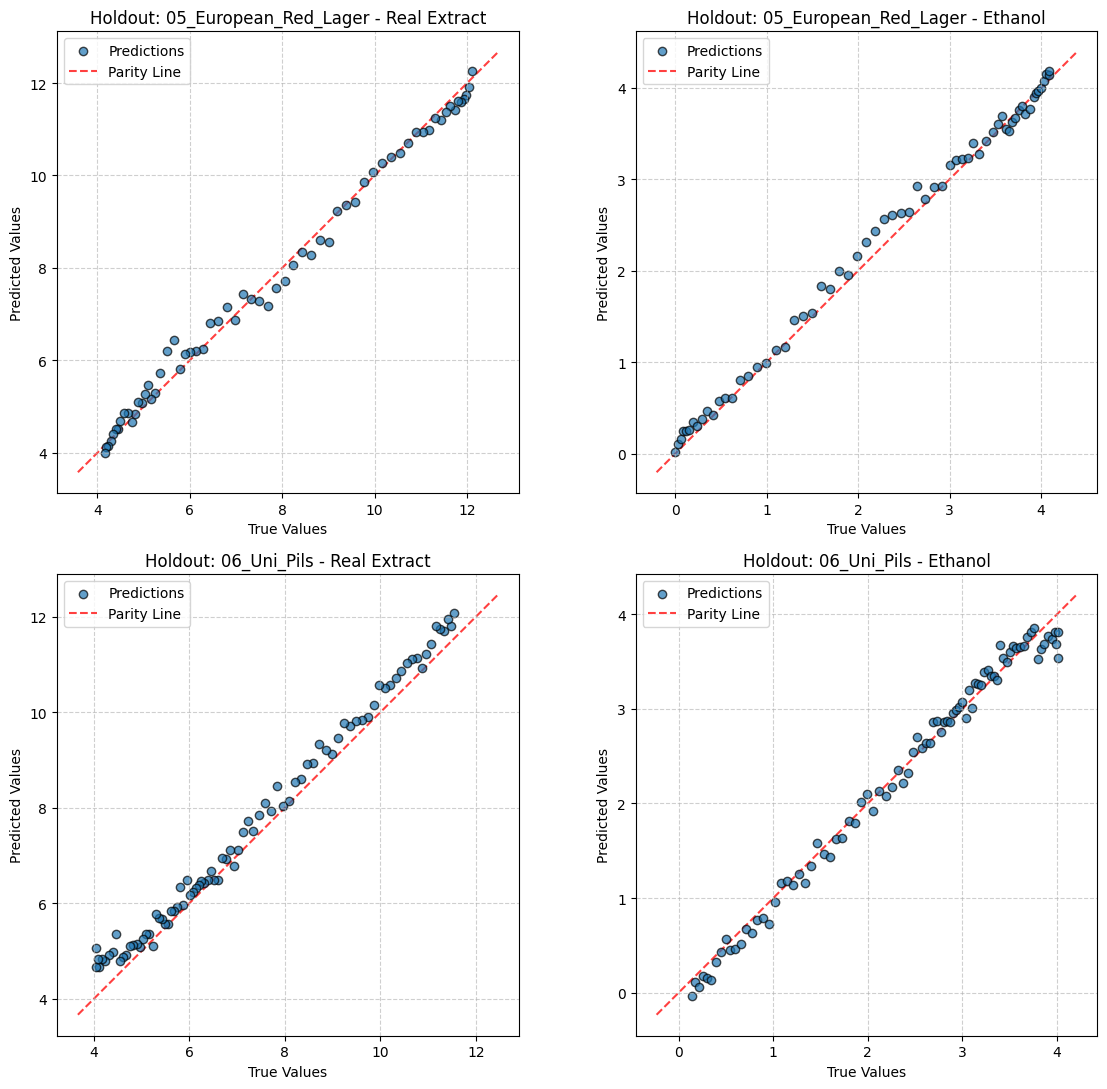

[{'holdout_batch': '05_European_Red_Lager',
  'best_params': {'regressor__emsc__order': np.int64(1),
   'regressor__mlp__activation': 'tanh',
   'regressor__mlp__alpha': 10,
   'regressor__mlp__hidden_layer_sizes': (20,),
   'regressor__sg__polynomial_order': np.int64(4),
   'regressor__sg__window_size': np.int64(18)},
  'mse_real_extract': np.float64(0.05789717111828706),
  'r2_real_extract': 0.9921138770179709,
  'mse_ethanol': np.float64(0.013656177390865101),
  'r2_ethanol': 0.9930174139826832},
 {'holdout_batch': '06_Uni_Pils',
  'best_params': {'regressor__emsc__order': np.int64(1),
   'regressor__mlp__activation': 'tanh',
   'regressor__mlp__alpha': 10,
   'regressor__mlp__hidden_layer_sizes': (20,),
   'regressor__sg__polynomial_order': np.int64(4),
   'regressor__sg__window_size': np.int64(19)},
  'mse_real_extract': np.float64(0.15198443424833705),
  'r2_real_extract': 0.9714196058752714,
  'mse_ethanol': np.float64(0.016897752511736332),
  'r2_ethanol': 0.9880365383036712}]

In [37]:
from NIRBeer.model_training import train_and_evaluate
from chemotools.feature_selection import RangeCut
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from chemotools.scatter import ExtendedMultiplicativeScatterCorrection
from chemotools.derivative import SavitzkyGolay
import numpy as np

df = selected_df
holdout_batch = ["05_European_Red_Lager", "06_Uni_Pils"]

pipeline = Pipeline([
        ('rangecut', RangeCut(30, -30)),
        ('emsc', ExtendedMultiplicativeScatterCorrection()),
        ('sg', SavitzkyGolay(derivate_order=1)),
        ('scaler', StandardScaler()),
        ('mlp', MLPRegressor(random_state=42, max_iter=1500, early_stopping=True, n_iter_no_change=15))
 ])

param_grid = {
        'regressor__mlp__hidden_layer_sizes': [(20,), (30,), (40,)],  # Example hidden layer sizes
        'regressor__mlp__alpha': [0.1, 1, 10],  # Example regularization strengths
        'regressor__mlp__activation': ['relu', 'tanh'],  # Example activation functions
        'regressor__emsc__order': np.arange(1, 2),  # Example orders to try
        'regressor__sg__window_size': np.arange(11, 20, 1),  # Example window sizes to try
        'regressor__sg__polynomial_order': np.arange(2, 5, 1),
    }

train_and_evaluate(df, holdout_batch, pipeline, f"models/MLP_gridsearch", separate_models=True, param_grid=param_grid)

## Final MLP models 


--- Training Separate Model 1/2 ---
Fitting model for holdout '05_European_Red_Lager' on 397 samples...
Model saved to 'models/MLP_final_without_05_European_Red_Lager.joblib'
Holdout MSE for Real Extract: 0.0678, $R^2$: 0.9908
Holdout MSE for Ethanol: 0.0137, $R^2$: 0.9930

--- Training Separate Model 2/2 ---
Fitting model for holdout '06_Uni_Pils' on 375 samples...
Model saved to 'models/MLP_final_without_06_Uni_Pils.joblib'
Holdout MSE for Real Extract: 0.1189, $R^2$: 0.9776
Holdout MSE for Ethanol: 0.0331, $R^2$: 0.9766


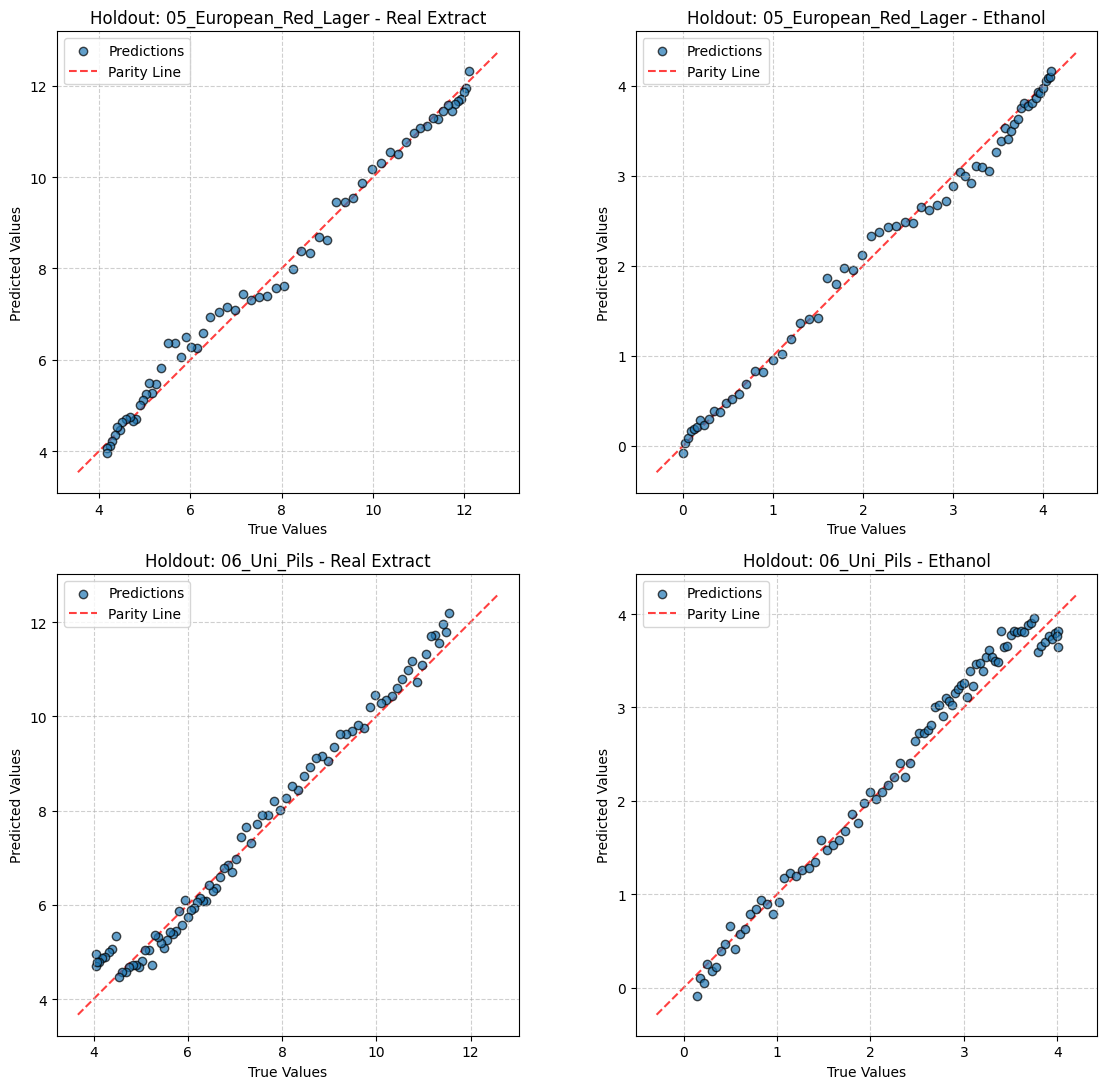

[{'holdout_batch': '05_European_Red_Lager',
  'best_params': 'Defaults',
  'mse_real_extract': np.float64(0.06781007488613468),
  'r2_real_extract': 0.9907636490757015,
  'mse_ethanol': np.float64(0.013666933079052245),
  'r2_ethanol': 0.9930119144555614},
 {'holdout_batch': '06_Uni_Pils',
  'best_params': 'Defaults',
  'mse_real_extract': np.float64(0.1188546289513758),
  'r2_real_extract': 0.9776496050021264,
  'mse_ethanol': np.float64(0.0330899142837895),
  'r2_ethanol': 0.9765726287094116}]

In [77]:
from NIRBeer.model_training import train_and_evaluate
from chemotools.feature_selection import RangeCut
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from chemotools.scatter import ExtendedMultiplicativeScatterCorrection
from chemotools.derivative import SavitzkyGolay

df = selected_df
holdout_batch = ["05_European_Red_Lager", "06_Uni_Pils"]

pipeline = Pipeline([
        ('rangecut', RangeCut(30, -30)),
        ('emsc', ExtendedMultiplicativeScatterCorrection(order=2)),
        ('sg', SavitzkyGolay(derivate_order=1, 
                             polynomial_order=3, 
                             window_size=16
                             )
        ),
        ('scaler', StandardScaler()),
        ('mlp', MLPRegressor(random_state=42,
                             max_iter=1500, 
                             early_stopping=True, 
                             n_iter_no_change=15,
                             activation='tanh',
                             alpha=10,
                             hidden_layer_sizes=(20,)
                             )
        )
 ])


train_and_evaluate(df, holdout_batch, pipeline, f"models/MLP_final", separate_models=True)

## Performance over course of fermentation
European Red Lager

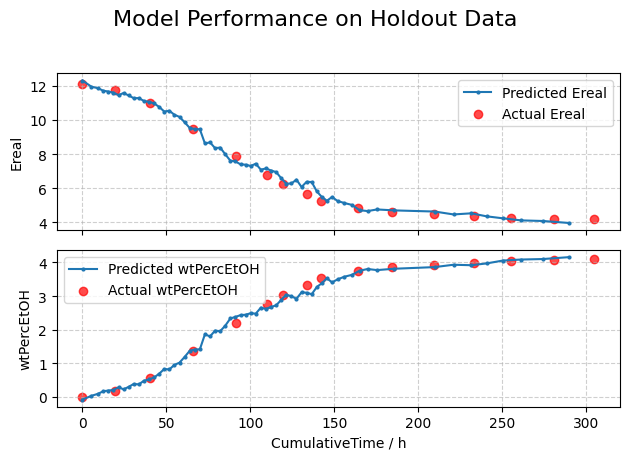

In [69]:
import joblib
from NIRBeer.visualization import plot_model_performance

holdout_batch = "05_European_Red_Lager"  # Change this to visualize different batches
best_model = joblib.load(f'models/MLP_final_without_{holdout_batch}.joblib')

plot_model_performance(
    model=best_model,
    spectra_holdout_df=selected_df,
    actuals_holdout_df=df_dsa,
    holdout_batch=holdout_batch,
    target_columns=["Ereal", "wtPercEtOH"]
)

Uni Pils

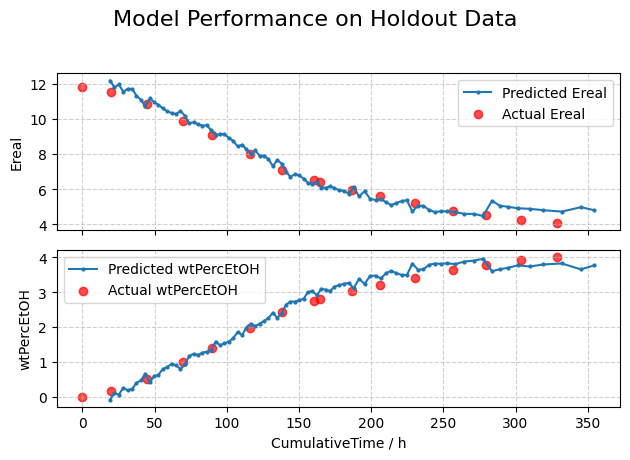

In [70]:
import joblib
from NIRBeer.visualization import plot_model_performance

holdout_batch = "06_Uni_Pils"  # Change this to visualize different batches
best_model = joblib.load(f'models/MLP_final_without_{holdout_batch}.joblib')

plot_model_performance(
    model=best_model,
    spectra_holdout_df=selected_df,
    actuals_holdout_df=df_dsa,
    holdout_batch=holdout_batch,
    target_columns=["Ereal", "wtPercEtOH"]
)